YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.5019 - val_loss: 0.4980
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4447 - val_loss: 0.4400
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4022 - val_loss: 0.4003
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3635 - val_loss: 0.3645
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3283 - val_loss: 0.3302
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2961 - val_loss: 0.3026
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2668 - val_loss: 0.2762
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2399 - val_loss: 0.2458
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2156 - val_loss: 0.2264
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1934 - val_loss: 0.2065
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1731 - val_loss: 0.1869
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/ste

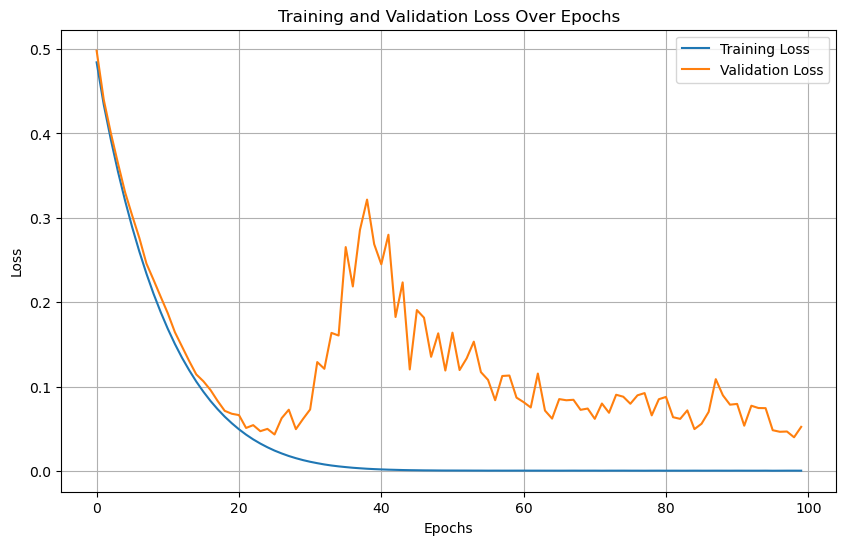

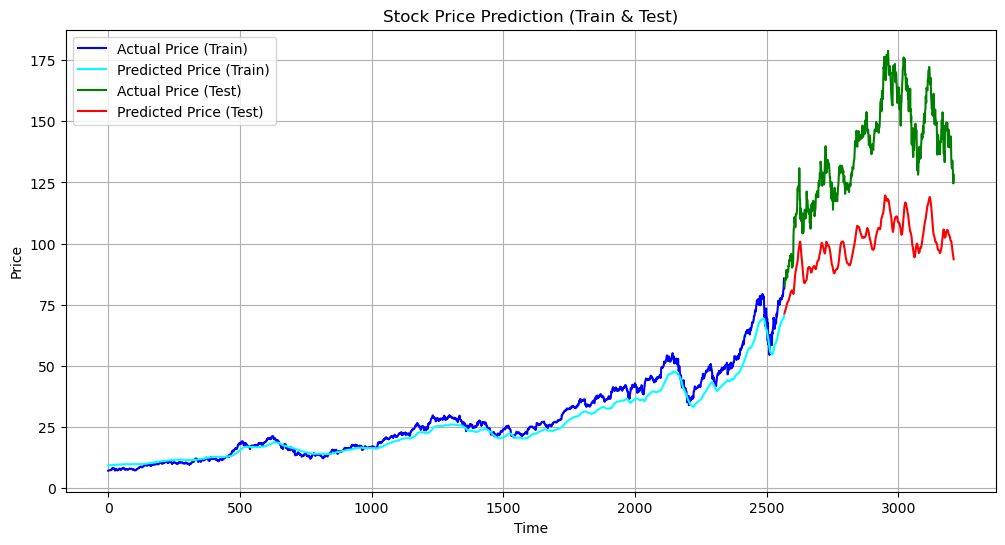

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense,
    LSTM, LayerNormalization, Add
)
import matplotlib.pyplot as plt

# 1. 下载股票数据
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')
data = data[['Open', 'High', 'Low', 'Close']]  # 选取多个特征

# 2. 数据预处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. 创建数据集
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # 使用所有特征
        y.append(data[i + time_step, -1])  # 预测收盘价
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. 构建 CNN + LSTM 模型
input_layer = Input(shape=(time_step, X.shape[2]))

# 第一层卷积
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# 第二层卷积
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# LSTM 层
x = LSTM(50, activation='relu', return_sequences=False)(x)

# 全连接层
x = Dense(50, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1)(x)

# 定义模型
model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# 5. 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 6. 预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化
train_predict_inv = scaler.inverse_transform(np.concatenate((X_train[:, -1, :-1], train_predict), axis=1))[:, -1]
test_predict_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], test_predict), axis=1))[:, -1]
y_train_inv = scaler.inverse_transform(np.concatenate((X_train[:, -1, :-1], y_train.reshape(-1, 1)), axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# 计算误差指标
train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
train_mse = mean_squared_error(y_train_inv, train_predict_inv)
test_mse = mean_squared_error(y_test_inv, test_predict_inv)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train_inv, train_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)

# 输出评估结果
print(f'Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train R^2: {train_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}')

# 保存评估指标
with open('evaluation_metrics(CNN-LSTM).txt', 'w') as f:
    f.write(f'Train MAE: {train_mae:.4f}\n')
    f.write(f'Train MSE: {train_mse:.4f}\n')
    f.write(f'Train RMSE: {train_rmse:.4f}\n')
    f.write(f'Train R^2: {train_r2:.4f}\n')
    f.write(f'Test MAE: {test_mae:.4f}\n')
    f.write(f'Test MSE: {test_mse:.4f}\n')
    f.write(f'Test RMSE: {test_rmse:.4f}\n')
    f.write(f'Test R^2: {test_r2:.4f}\n')

# 7. 可视化损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot(CNN-LSTM).png')
plt.show()

# 8. 可视化训练和测试集的预测结果
plt.figure(figsize=(12, 6))

# 训练集的实际值和预测值
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Actual Price (Train)', color='blue')
plt.plot(np.arange(len(y_train_inv)), train_predict_inv, label='Predicted Price (Train)', color='cyan')

# 测试集的实际值和预测值
plt.plot(np.arange(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), y_test_inv, label='Actual Price (Test)', color='green')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), test_predict_inv, label='Predicted Price (Test)', color='red')

plt.title('Stock Price Prediction (Train & Test)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# 保存并显示图像
plt.savefig('prediction_plot(CNN-LSTM).png')
plt.show()
